# Check ToM ROIs
Natalia Vélez, February 2022

In [1]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
from nilearn import image,plotting
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj

sys.path.append('..')
from utils import gsearch

sns.set_style('white')
sns.set_context('talk')

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Make output directory:

In [2]:
out_dir = 'outputs/roi_picker'
os.makedirs(out_dir, exist_ok=True)

Find ROI files:

In [3]:
data_dir = '../../BIDS_data/derivatives/'
roi_dir = opj(data_dir, 'roi_picker')

roi_files = gsearch(roi_dir, '**', 'func', '*.nii.gz')
roi_files.sort()

print('Found %i ROI files' % len(roi_files))
print(*roi_files[:10], sep='\n')

Found 194 ROI files
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-MMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-PC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RSTS_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-VMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../

## Tally functional ROIs

Tally files

In [4]:
roi_df = pd.DataFrame({'path': roi_files})
roi_df['subject'] = roi_df.path.str.extract('(sub-[0-9]{2})')
roi_df['roi'] = roi_df.path.str.extract('(?<=desc-)([A-Z]+)')
roi_df.head()

,path,subject,roi
0,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,DMPFC
1,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,LTPJ
2,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,MMPFC
3,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,PC
4,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,RSTS


Did all participants run successfully?

In [5]:
roi_df['subject'].agg('nunique')

28

How many participants have each ROI?

In [6]:
roi_df.groupby('roi').agg({'subject': 'nunique'})

,subject
roi,
DMPFC,28
LTPJ,28
MMPFC,27
PC,28
RSTS,28
RTPJ,28
VMPFC,27


Who's missing ROIs?

In [7]:
roi_pivot = roi_df.groupby(['subject', 'roi']).size().unstack(fill_value=0).astype(bool)
roi_pivot[~roi_pivot.all(axis=1)]

roi,DMPFC,LTPJ,MMPFC,PC,RSTS,RTPJ,VMPFC
subject,,,,,,,
sub-11,True,True,False,True,True,True,False


## Check ROI location and extent

Plot locations and extent of each ROI:

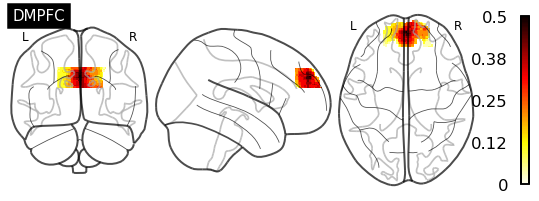

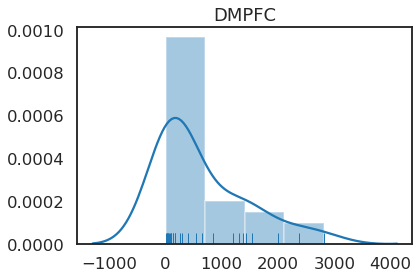

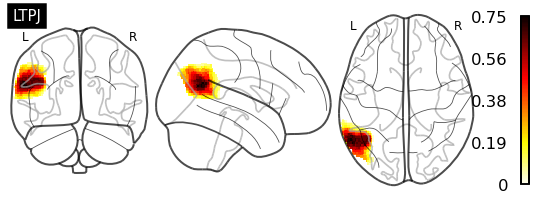

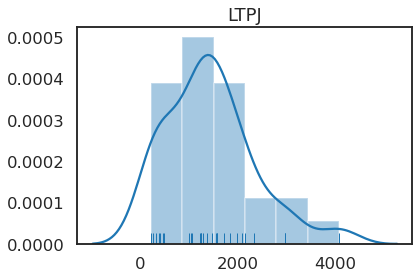

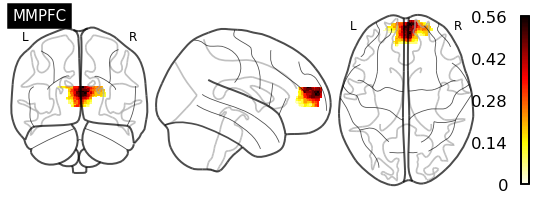

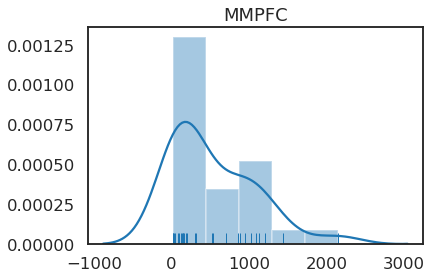

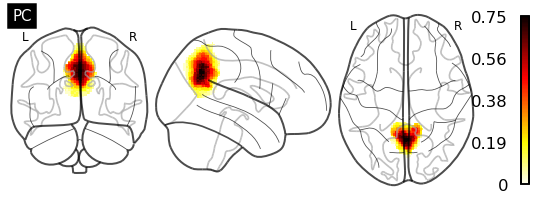

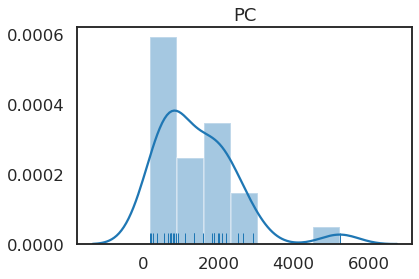

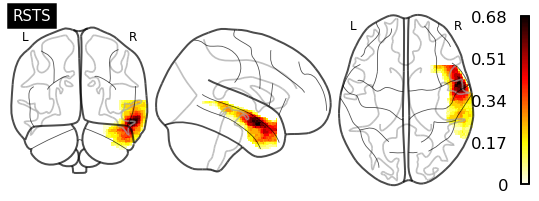

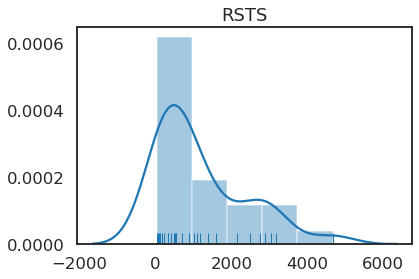

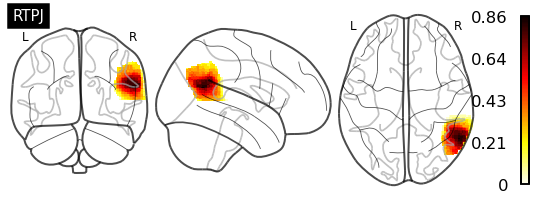

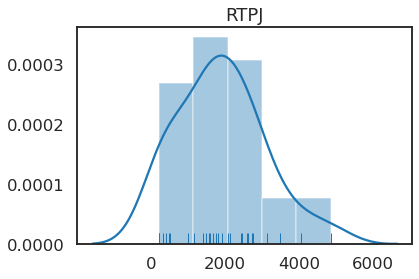

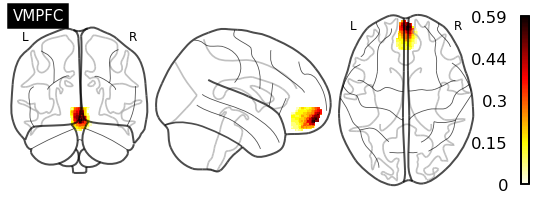

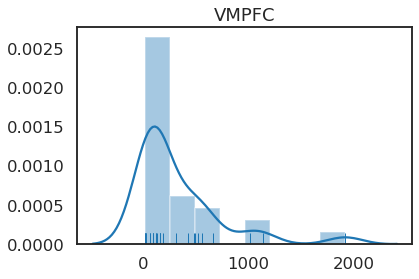

In [15]:
extent_list = []

for name, group in roi_df.groupby('roi'):
    # Load all ROI images
    roi_images = image.load_img(group.path.values.tolist())

    # Plot mean ROI
    mean_roi = image.mean_img(roi_images)
    mean_roi_plot = plotting.plot_glass_brain(mean_roi, colorbar=True, title=name)
    mean_roi_plot.savefig(opj(out_dir, '%s_location.png' % name))

    # Get ROI extent
    roi_extents = np.apply_over_axes(np.sum, roi_images.dataobj, range(roi_images.dataobj.ndim - 1)).flatten()
    roi_extents_df = group.copy()
    roi_extents_df['extent'] = roi_extents
    extent_list.append(roi_extents_df)

    fig,ax=plt.subplots()
    sns.distplot(roi_extents, rug=True, ax=ax)
    ax.set(title=name)
    plt.savefig(opj(out_dir, '%s_extent.png' % name))

Put together dataframe of ROI extents

In [20]:
all_roi_extents = pd.concat(extent_list)
all_roi_extents.to_csv(opj(out_dir, 'all_roi_extents.csv'), index=False)
all_roi_extents.groupby('roi').agg({'extent': ['min', 'max', 'median']})

extent                
         min     max  median
roi                         
DMPFC   11.0  2815.0   220.0
LTPJ   215.0  4067.0  1326.0
MMPFC   16.0  2151.0   308.0
PC     172.0  5231.0  1229.5
RSTS    46.0  4667.0   619.5
RTPJ   220.0  4858.0  1789.0
VMPFC   12.0  1914.0   154.0